# Augmented Reality System for Tourists in Oslo

Our jupyter notebook will use harris and sift algorithms to recognize a historic building in Oslo from an image.

We first find about 5 photos of each building, varying the brightness, angle etc. on google images, which form our database. And then a test photo for each building.

We calculate the descriptors of each image we store using the two algorithms.

Then, for each photo in the test folder, we calculate the number of matches with each photo in the database. The building with the most matches will therefore be the one on the test photo. 



In [3]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors, plot_matched_features
from skimage import transform
import cv2
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

# Harris method

### Preprocessing part

We first want to preprocess each photo we grey them and normalize them so that all images are processed from similar information

In [4]:
def preprocess_image(img_path, target_size=None, sigma=1):
    """
    Standard preprocessing:
    - grayscale
    - resize (optional)
    - normalize (zero mean, unit variance)
    - gaussian smoothing
    """
    im = np.array(Image.open(img_path).convert('L'), dtype=np.float32)
    if target_size:
        im = np.array(Image.fromarray(im).resize(target_size, Image.BICUBIC), dtype=np.float32)
    im = (im - np.mean(im)) / (np.std(im) + 1e-8)
    return gaussian_filter(im, sigma=sigma)

The next function are from the Chapter 2 of the book. They build the basis of the harris method

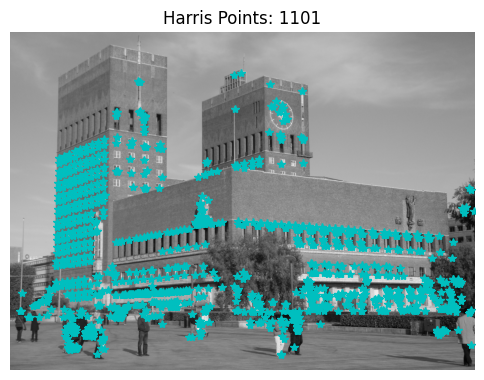

In [6]:
def compute_harris_response(im, sigma=3):
    """ Harris corner response. """
    imx = np.zeros_like(im)
    imy = np.zeros_like(im)
    gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    gaussian_filter(im, (sigma, sigma), (1, 0), imy)

    Wxx = gaussian_filter(imx * imx, sigma)
    Wxy = gaussian_filter(imx * imy, sigma)
    Wyy = gaussian_filter(imy * imy, sigma)

    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet / (Wtr + 1e-8)


def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    """ Extract Harris points above threshold with min distance. """
    coords = np.array((harrisim > harrisim.max() * threshold).nonzero()).T
    values = harrisim[coords[:, 0], coords[:, 1]]
    index = np.argsort(values)[::-1]  # tri décroissant

    allowed = np.zeros(harrisim.shape, dtype=bool)
    allowed[min_dist:-min_dist, min_dist:-min_dist] = True

    selected = []
    for i in index:
        y, x = coords[i]
        if allowed[y, x]:
            selected.append((y, x))
            allowed[y - min_dist:y + min_dist + 1, x - min_dist:x + min_dist + 1] = False
    return selected


def get_descriptors(image, coords, wid=5):
    """ Extract patch descriptors around each point. """
    desc = []
    for y, x in coords:
        patch = image[y - wid:y + wid + 1, x - wid:x + wid + 1]
        if patch.shape == (2 * wid + 1, 2 * wid + 1):  # ignore borders
            desc.append(patch.flatten())
    return np.array(desc)


def plot_harris_points(image, coords):
    plt.figure(figsize=(6, 6))
    plt.gray()
    plt.imshow(image)
    if coords:
        plt.plot([x for _, x in coords], [y for y, _ in coords], 'c*')
    plt.title(f"Harris Points: {len(coords)}")
    plt.axis('off')
    plt.show()

wid=5
harris_threshold = 0.2
im = preprocess_image("data/images/city_hall/city_hall1.jpg")
harrisim = compute_harris_response(im)
coords = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
descriptors = get_descriptors(im, coords, wid)

plot_harris_points(im, coords)

We are now going to use these method to create a database. 

Each photo will be computed and we will put in a txt file the descriptors to being able to calculate matches without compute the descriptors every round. 

In [11]:
def preprocess_harris_dataset(data_dir, feature_dir, harris_threshold=0.3, wid=5):
    """ Preprocess a dataset of images to extract and save Harris features. """
    os.makedirs(feature_dir, exist_ok=True)

    for landmark in os.listdir(data_dir):
        landmark_path = os.path.join(data_dir, landmark)
        if not os.path.isdir(landmark_path):
            continue

        out_path = os.path.join(feature_dir, landmark)
        os.makedirs(out_path, exist_ok=True)

        for img_name in os.listdir(landmark_path):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            img_path = os.path.join(landmark_path, img_name)
            im = preprocess_image(img_path)
            harrisim = compute_harris_response(im)
            coords = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
            descriptors = get_descriptors(im, coords, wid)


            out_file = os.path.join(out_path, img_name.rsplit('.', 1)[0] + '.txt')
            with open(out_file, 'w') as f:
                for c, d in zip(coords, descriptors):
                    line = ','.join(map(str, [c[0], c[1]] + list(d)))
                    f.write(line + '\n')

            print(f"Processed {img_name} ({landmark}), {len(coords)} points.")

def load_features(feature_dir):
    """ Load coords + descriptors from txt files. """
    features = {}
    for landmark in os.listdir(feature_dir):
        l_path = os.path.join(feature_dir, landmark)
        if not os.path.isdir(l_path):
            continue
        features[landmark] = {}
        for f in os.listdir(l_path):
            if not f.endswith('.txt'):
                continue
            coords, desc = [], []
            with open(os.path.join(l_path, f)) as file:
                for line in file:
                    vals = list(map(float, line.strip().split(',')))
                    coords.append([int(vals[0]), int(vals[1])])
                    desc.append(np.array(vals[2:]))
            features[landmark][f] = (coords, np.array(desc))
    return features

### Matching part

We will try to match two photos with the matching function from the book also on chapter 2

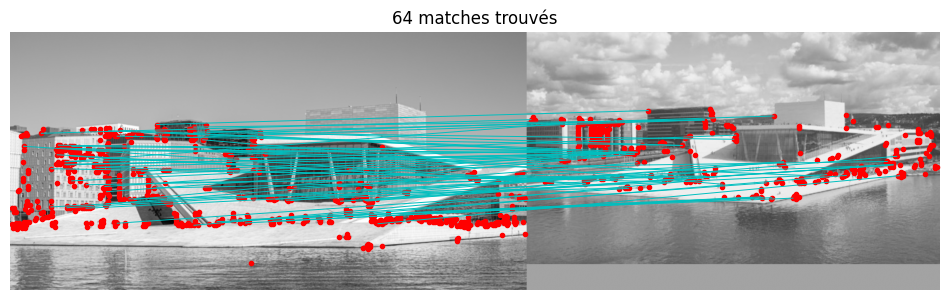

In [12]:
def match(desc1, desc2, locs1, locs2, ncc_thresh=0.6, dist_thresh=200, ratio=0.8):
    """ Match descriptors using NCC with distance & ratio tests. """
    matches = []
    n = desc1.shape[1]

    for i, d1 in enumerate(desc1):
        d1n = (d1 - np.mean(d1)) / (np.std(d1) + 1e-8)
        scores = []

        for j, d2 in enumerate(desc2):
            if np.linalg.norm(np.array(locs1[i]) - np.array(locs2[j])) > dist_thresh:
                continue
            d2n = (d2 - np.mean(d2)) / (np.std(d2) + 1e-8)
            ncc = np.sum(d1n * d2n) / (n - 1)
            if ncc > ncc_thresh:
                scores.append((j, 1 - ncc))

        if len(scores) >= 2:
            scores.sort(key=lambda x: x[1])
            best, second = scores[:2]
            if best[1] / (second[1] + 1e-8) < ratio:
                matches.append((i, best[0]))

    return matches


def plot_image_matches(img1_path, img2_path, ncc_thresh=0.6, harris_threshold=0.3, wid=5, dist_thresh=200, ratio=0.8):
    """
    Show matches between two images using Harris corners and NCC.
    """
    # Prétraitement
    im1 = preprocess_image(img1_path)
    im2 = preprocess_image(img2_path)

    # Harris + descripteurs
    harrisim1 = compute_harris_response(im1)
    harrisim2 = compute_harris_response(im2)
    coords1 = get_harris_points(harrisim1, min_dist=wid + 1, threshold=harris_threshold)
    coords2 = get_harris_points(harrisim2, min_dist=wid + 1, threshold=harris_threshold)
    desc1 = get_descriptors(im1, coords1, wid)
    desc2 = get_descriptors(im2, coords2, wid)

    # Match
    matches = match(desc1, desc2, coords1, coords2,
                    ncc_thresh=ncc_thresh, dist_thresh=dist_thresh, ratio=ratio)

    # Plot côte à côte
    plt.figure(figsize=(12, 6))
    plt.gray()

    # Concaténer horizontalement
    h1, w1 = im1.shape
    h2, w2 = im2.shape
    h = max(h1, h2)
    concat_img = np.zeros((h, w1 + w2))
    concat_img[:h1, :w1] = im1
    concat_img[:h2, w1:w1 + w2] = im2
    plt.imshow(concat_img)

    # Points Harris
    for y, x in coords1:
        plt.plot(x, y, 'ro', markersize=3)
    for y, x in coords2:
        plt.plot(x + w1, y, 'ro', markersize=3)

    # Lignes de correspondance
    for i, j in matches:
        y1, x1 = coords1[i]
        y2, x2 = coords2[j]
        plt.plot([x1, x2 + w1], [y1, y2], 'c-', linewidth=0.7)

    plt.title(f"{len(matches)} matches trouvés")
    plt.axis('off')
    plt.show()

    return matches


ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

img1 = r"data\images\opera\opera1.jpg"
img2 = r"data\images\opera\opera2.jpg"
matches = plot_image_matches(img1, img2, ncc_thresh=ncc_thresh, ratio=ratio, dist_thresh=dist_thresh,harris_threshold=harris_threshold, wid=5)


### Classifying Part

As the goal is to classify a new image we will now take the new image and compare it to every image in our database. 

The one with the most matches will be use to define the new image. 

New Image descriptors: 


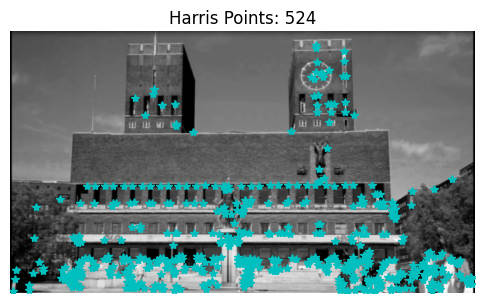

Comparing city_hall1.txt (city_hall): 23 matches
Comparing city_hall2.txt (city_hall): 42 matches
Comparing city_hall3.txt (city_hall): 0 matches
Comparing city_hall4.txt (city_hall): 136 matches
Comparing fram1.txt (fram): 55 matches
Comparing fram2.txt (fram): 44 matches
Comparing fram3.txt (fram): 4 matches
Comparing fram4.txt (fram): 74 matches
Comparing opera1.txt (opera): 114 matches
Comparing opera2.txt (opera): 100 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 49 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 68 matches
Comparing palace2.txt (palace): 35 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 2 matches
Comparing palace5.txt (palace): 32 matches
Comparing vigeland1.txt (vigeland): 102 matches
Comparing vigeland2.txt (vigeland): 35 matches
Comparing vigeland3.txt (vigeland): 0 matches
Comparing vigeland4.txt (vigeland): 59 matches

city_hall_test is identified as city_hall


In [ ]:
def classify_image(new_img_path, features, ncc_thresh=0.6, harris_threshold=0.2, wid=5, dist_thresh=500, ratio=0.8):
    im = preprocess_image(new_img_path)
    harrisim = compute_harris_response(im)
    coords_new = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
    desc_new = get_descriptors(im, coords_new, wid)

    plot_harris_points(im, coords_new)

    best_score, best_landmark, best_image = -1, None, None
    for landmark, images in features.items():
        for img_name, (coords_ref, desc_ref) in images.items():
            if len(desc_ref) == 0 or len(desc_new) == 0:
                continue
            matches = match(desc_new, desc_ref, coords_new, coords_ref,
                            dist_thresh=dist_thresh, ratio=ratio, ncc_thresh=ncc_thresh)
            num = len(matches)
            print(f"Comparing {img_name} ({landmark}): {num} matches")

            if num > best_score:
                best_score, best_landmark, best_image = num, landmark, img_name

    return best_landmark, best_image, best_score

data_dir = r"data\images"
feature_dir = r"data\features"

ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

# decomment to preprocess the dataset only once
#preprocess_harris_dataset(data_dir, feature_dir, harris_threshold=harris_threshold, wid=5)

features = load_features(feature_dir)
print("New Image descriptors: ")
img_path=r"data\test\city_hall_test.jpg"
img_name="city_hall_test"
landmark, ref_img, score = classify_image(
        img_path, features,
        ncc_thresh=ncc_thresh,
        dist_thresh=dist_thresh,
        ratio=ratio,
        harris_threshold=harris_threshold,
        wid=wid
)
print(f"\n{img_name} is identified as {landmark}\nRef: {ref_img}, Matches: {score}")



To do it on every image of the test dataset run the below code (long computed time)

In [ ]:
def classify_test_folder(test_dir, features, ncc_thresh=0.5, ratio=0.5, dist_thresh=200, harris_threshold=0.2, wid=5):
    """
    Parcourt toutes les images dans test_dir, applique la classification Harris
    et retourne un dictionnaire {nom_image: (landmark, ref_img, score)}.
    """
    results = {}

    for img_name in os.listdir(test_dir):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.avif')):
            continue

        img_path = os.path.join(test_dir, img_name)
        landmark, ref_img, score = classify_image(
            img_path, features,
            ncc_thresh=ncc_thresh,
            dist_thresh=dist_thresh,
            ratio=ratio,
            harris_threshold=harris_threshold,
            wid=wid
        )
        
        results[img_name] = (landmark, ref_img, score)
        print(f"[{img_name}] -> Landmark: {landmark}, Ref: {ref_img}, Matches: {score}")

    return results

test_dir = r"data\test"

ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

results = classify_test_folder(
    test_dir, features,
    ncc_thresh=ncc_thresh,
    ratio=ratio,
    dist_thresh=dist_thresh,
    harris_threshold=harris_threshold,
    wid=5
)